# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [3]:
# Change here using YOUR first and last names
fn1 = "robert"
ln1 = "gower"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_gower_robert_and_gramfort_alexandre.ipynb


Some imports

In [4]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

Let us call $f(w,\rho,\xi) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i  $, f is obvously convex in w (the hessian is just the identity), and linear in $\rho$ and $\xi$. All the constraints are linear, thus the problem is convex 

ANSWER HERE

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

The problem $(\mathcal{P})$ can be rewritten in two sub-problems (we just need to find the better solution between both): 
$$ (\mathcal{P_1})\left\{
    \begin{array}{ll}
    \min_{w,\rho} &\frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n (\rho - \langle w, x_i \rangle) \, 
    \\
    \langle w,x_i \rangle - \rho\leq 0 
    \end{array}
    \right.
    $$
And 
$$(\mathcal{P_2})\left\{
    \begin{array}{ll}
    \min_{w,\rho} \frac{1}{2}\Vert w \Vert^2 - \rho  
    \\
    \rho - \langle w,x_i \rangle   \leq 0 
    \end{array}
    \right.
    $$
    


Let us consider the problem $(\mathcal{P_1})$: 

For this problem we can write the Lagrangian, let us define : $\lambda \in \mathbb{R}^n_+$ 
$$\mathcal{L}(w,\rho,\lambda) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n (\rho - \langle w, x_i \rangle) + \sum_{i=1}^n \lambda_i (\langle w,x_i \rangle - \rho)$$

By definition the dual problem is : 
$$(\mathcal{D_1}) : \max_\lambda g(\lambda)  $$ 
Where $g(\lambda)  = \inf_{w,\rho}  \mathcal{L} (w,\rho,\lambda)$ is the dual fonction 
Because strong convexity holds, the primal and dual problems are equivalent
Let us call $w^*$ and $\rho^*$ the optima, we have: 
  $$\frac{\partial \mathcal{L}}{w}(w^*, \rho,\lambda) = 0 $$
  Thus 
  $$w^* + \sum_{i=1}^n ( - \frac{1}{ \nu n } + \lambda_i ) x_i = 0 $$
  And 
  $$ \boxed{w^* = \sum_{i=1}^n (\frac{1}{ \nu n } -  \lambda_i ) x_i}$$
  
  We also have: 
   $$\frac{\partial \mathcal{L}}{\rho}(w, \rho^* ,\lambda) = 0 $$
   $$-1 + \frac{1}{\nu } - \lambda^T1_n = 0$$
   $$\boxed{\lambda^T1_n = -1 + \frac {1}{\nu}} $$
   
   Let us define $$\mu = \frac{1_n}{\nu n} - \lambda$$ 
   Our two equalities can be written 
   $$\boxed{w^* = \sum_{i=1}^n \mu_i  x_i = G^T\mu}$$
   Where $G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix} $
   $$\boxed{\mu^T1_n = 1 } $$
   
   Thus $$g(\mu) = \frac{1}{2}\Vert w^* \Vert^2 - \rho^* + \frac{1}{\nu n} \sum_{i=1}^n (\rho^*  - \langle w^*, x_i \rangle) + \sum_{i=1}^n \lambda_i (\langle w^*,x_i \rangle - \rho^*)$$
   $$g(\mu) = \frac{1}{2} \mu^T G G^T \mu  - \rho^* + \frac{1}{\nu} \rho^* - \lambda^T 1_n \rho^* - \sum_{i=1}^n (\frac{1}{\nu n } - \lambda_i) \langle G^T \mu, x_i \rangle  $$
   Substituting $\lambda$ fo $\mu$ we get :
   $$g(\mu) = \frac{1}{2} \mu^T G G^T \mu  - \rho^* + \mu^T 1_n - \mu^T G G^T \mu $$
   as $\mu^T1_n = 1 $ We have 
   $$\boxed{g(\mu) = -\frac{1}{2} \mu^T G G^T \mu} $$
   Moreover $ \lambda \in \mathcal{R}^n_+ \implies  \mu \leq \frac{1}{\nu n}$
   
   Thus, the dual problem associated with problem $ (\mathcal{P_1})$ is (maximizing an negative is the same as minimizing a positive) :
   $$
(\mathcal{D_1}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}&\mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

Let us now consider the problem $\mathcal{P_2}$ 
The lagrangian is: 
$$\mathcal{L}(w,\rho,\mu) = \frac{1}{2}\Vert w \Vert^2 - \rho + \sum_{i=1}^n \mu_i (\rho -\langle w,x_i \rangle )$$
With $ \mu \in \mathbb{R}^n_+ $ 
Using the same notation as above we have: 
  $$\frac{\partial \mathcal{L}}{w}(w^*, \rho,\mu ) = 0 \implies w^* = G^T \mu  $$
  AND 
  $$\frac{\partial \mathcal{L}}{\rho}(w, \rho^* ,\mu) = 0 \implies \mu^T 1_n = 1  $$

Thus by the same computation than above, the dual problem associated with problem $(\mathcal{P_2})$ is: 
   $$
(\mathcal{D_2}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu 
 \end{array}
 \right .
$$

Putting the two results together we get the full dual problem: 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>

The decision function is given by: 
$$y = sign(\langle w,x \rangle - \rho) $$ where w and $\rho$ are the optimal values
We found in question 2 that at the optimum: 
$$ w =  \sum_{i=1}^{n} \mu_i x_i$$
Thus,the prediction function is: 
 $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$


## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

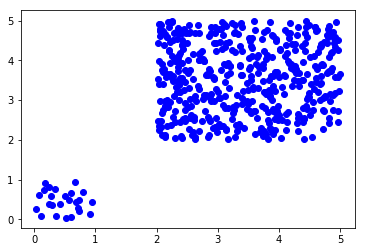

In [5]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_dataset(500)
plt.scatter(X[:, 0], X[:, 1], color='b');

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [7]:
import cvxopt


def qp(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
 
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [8]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

In [56]:
# TODO
def ocsvm_solver(K, nu=0.1):
    n = K.shape[0]
    P = np.dot(X,X.T)
    q = np.zeros(n)
    A = np.ones((1,n))
    b = np.ones(1)
    C = 1/(nu*n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)
# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver(K)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 50


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

In [60]:
# TODO
w = np.zeros(X.shape[0])
w[idx_support] = mu_support

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

ANSWER HERE

In [10]:
# TODO

def compute_rho(K, mu_support, idx_support):
    # TODO
    K_support = K[idx_support][:, idx_support]
    rho = None
    return rho

compute_rho = compute_rho(K, mu_support, idx_support)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [12]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

# Check indices of support vectors
print(ocsvm.support_)
print(idx_support)

# Check rho
print(rho)
print(-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]
2.16400352023
2.16400355501
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

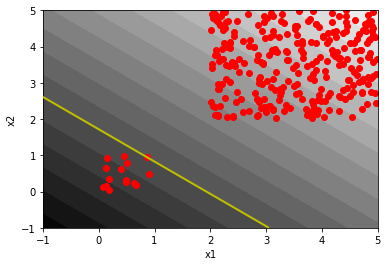

In [13]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function
    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

ANSWER HERE

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

ANSWER HERE

We will use another dataset to evaluate this:

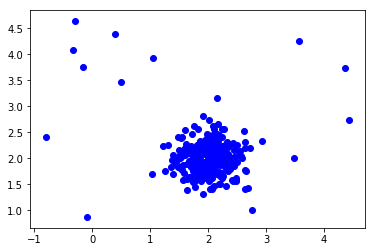

In [6]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [15]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = 0  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

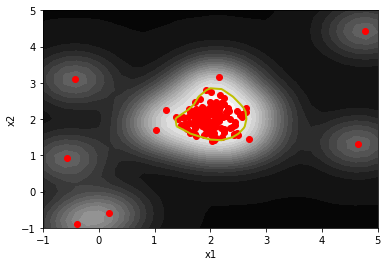

In [17]:
X = make_blob_dataset(150)

K = rbf_kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)

plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>

ANSWER HERE

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



ANSWER HERE

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**

In [18]:
# TODO

from scipy.optimize import fmin_l_bfgs_b